In [1]:
import networkx as nx
import numpy as np
import pickle
import gpflow
import os
import tensorflow as tf
import tensorflow_probability as tfp
from scipy import sparse
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
from gpflow.ci_utils import ci_niter

from graph_matern.kernels.graph_matern_kernel import GraphMaternKernel
from graph_matern.kernels.graph_diffusion_kernel import GraphDiffusionKernel
from graph_matern.inducing_variables import GPInducingVariables

In [2]:
dtype = tf.float64
gpflow.config.set_default_float(dtype)
gpflow.config.set_default_summary_fmt("notebook")
np.random.seed(1)

In [3]:
n_nodes_wh = 20
n_nodes = n_nodes_wh * n_nodes_wh
G = nx.grid_2d_graph(n_nodes_wh, n_nodes_wh)

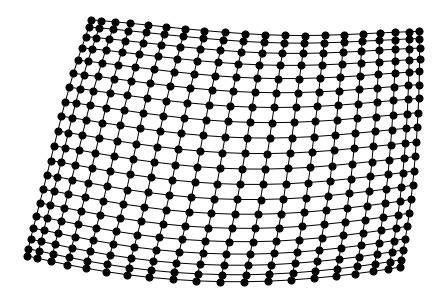

In [7]:
options = {
    'node_color': 'black',
    'node_size': 50,
    'width': 1,
}
pos = nx.spring_layout(G, iterations=500)
nx.draw(G, pos, **options)

In [6]:
num_eigenpairs = 500
laplacian = sparse.csr_matrix(nx.laplacian_matrix(G), dtype=np.float64)
# eigenvalues, eigenvectors = tf.linalg.eigh(laplacian.todense().astype(float))  # only should be done once-per-graph
eigenvalues, eigenvectors = tf.linalg.eigh(laplacian.toarray())
eigenvectors, eigenvalues = eigenvectors[:, :num_eigenpairs], eigenvalues[:num_eigenpairs]
eigenvalues, eigenvectors = tf.convert_to_tensor(eigenvalues, dtype=dtype), tf.convert_to_tensor(eigenvectors, dtype)

Follow LVM example.

In [9]:
data = sklearn.datasets.load_digits()
Y = tf.convert_to_tensor(data["data"], dtype=gpflow.default_float())
labels = tf.convert_to_tensor(data["target"])

In [32]:
num_data = Y.shape[0]  # number of data points

In [33]:
# lengthscales = tf.convert_to_tensor([1.0] * latent_dim, dtype=gpflow.default_float())
# lengthscales = tf.convert_to_tensor(1.0, dtype=gpflow.default_float())
kernel = GraphDiffusionKernel((eigenvectors, eigenvalues))#, kappa=lengthscales)

In [21]:
X_data_mean = tfp.distributions.Categorical(tf.repeat(1/n_nodes, n_nodes), dtype=dtype).sample(num_data)
X_data_mean = tf.reshape(X_data_mean, (-1, 1))
X_data_var = tf.ones((num_data, 1), dtype=gpflow.default_float())

In [36]:
X_data_mean

<tf.Tensor: shape=(1797, 1), dtype=float64, numpy=
array([[303.],
       [ 10.],
       [282.],
       ...,
       [392.],
       [236.],
       [363.]])>

In [22]:
inducing_points = GPInducingVariables(X_data_mean)
inducing_points

name,class,transform,prior,trainable,shape,dtype,value
GPInducingVariables.x_v,Parameter,Identity,,True,"(1797, 0)",float64,[]


In [27]:
GPInducingVariables??

Init signature: GPInducingVariables(x)
Source:        
class GPInducingVariables(InducingVariables):
    """
       Graph inducing points.
       The first coordinate is vertex index.
       Other coordinates are matched with points on \R^d.
       Note that vertex indices are not trainable.
    """
    def __init__(self, x):
        self.x_id = x[:, :1]
        if len(x.shape) > 1:
            self.x_v = gpflow.Parameter(x[:, 1:], dtype=gpflow.default_float())

        self.N = self.x_id.shape[0]

    def __len__(self):

        return self.N

    @property
    def GP_IV(self):
        return tf.concat([self.x_id, self.x_v], axis=1)
File:           ~/dev/shit/Graph-Gaussian-Processes/graph_matern/inducing_variables.py
Type:           type
Subclasses:     


In [ ]:
inducing_points

In [38]:
gplvm = gpflow.models.BayesianGPLVM(
    Y,
    X_data_mean=X_data_mean,
    X_data_var=X_data_var,
    kernel=kernel,
#     inducing_variable=inducing_points,
    inducing_variable=X_data_mean,
)
gplvm.likelihood.variance.assign(0.01)

<tf.Variable 'UnreadVariable' shape=() dtype=float64, numpy=-4.600266525158521>

In [25]:
gplvm.trainable_variables

(<tf.Variable 'Variable:0' shape=(1797, 1) dtype=float64, numpy=
 array([[303.],
        [ 10.],
        [282.],
        ...,
        [392.],
        [236.],
        [363.]])>,
 <tf.Variable 'Variable:0' shape=(1797, 1) dtype=float64, numpy=
 array([[0.54132485],
        [0.54132485],
        [0.54132485],
        ...,
        [0.54132485],
        [0.54132485],
        [0.54132485]])>,
 <tf.Variable 'Variable:0' shape=(1797, 0) dtype=float64, numpy=array([], shape=(1797, 0), dtype=float64)>,
 <tf.Variable 'kappa:0' shape=() dtype=float64, numpy=3.9815145531741134>,
 <tf.Variable 'sigma_f:0' shape=() dtype=float64, numpy=0.5413248546129181>,
 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-4.600266525158521>)

In [29]:
opt = gpflow.optimizers.Scipy()
maxiter = ci_niter(1000)
_ = opt.minimize(
    gplvm.training_loss,
    method="BFGS",
    variables=gplvm.trainable_variables,
    options=dict(maxiter=maxiter),
)

ValueError: in user code:

    /home/mochar/anaconda3/lib/python3.7/site-packages/gpflow/optimizers/scipy.py:105 _tf_eval  *
        return loss, cls.pack_tensors(grads)
    /home/mochar/anaconda3/lib/python3.7/site-packages/gpflow/optimizers/scipy.py:132 pack_tensors  *
        flats = [tf.reshape(tensor, (-1,)) for tensor in tensors]
    /home/mochar/anaconda3/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper  **
        return target(*args, **kwargs)
    /home/mochar/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/array_ops.py:195 reshape
        result = gen_array_ops.reshape(tensor, shape, name)
    /home/mochar/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/gen_array_ops.py:8378 reshape
        "Reshape", tensor=tensor, shape=shape, name=name)
    /home/mochar/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py:540 _apply_op_helper
        (input_name, err))

    ValueError: Tried to convert 'tensor' to a tensor and failed. Error: None values not supported.
